<a href="https://colab.research.google.com/github/AdrianUrbanski/BSD/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

## Imports

In [ ]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
import nltk
from collections import Counter
import csv
from tqdm.auto import tqdm
from scipy import stats
from google.colab import output

from sklearn import svm
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

## Data input

In [ ]:
def read_data(path, delimiter='|'):
    data = []
    with open(path, 'r') as file:
        reader = csv.reader(file, delimiter=delimiter)
        for row in reader:
            data.append(row)
    return data

## Feature extraction

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [ ]:
def extract(text):
    features = {}
    
    features["insane_punctuation_count"] = len(re.findall('[^\w\s\'\"]{3,}', text))

    tokens = nltk.word_tokenize(text)
    tokens_count = len(tokens)

    features["tokens_count"] = tokens_count

    tagged = nltk.pos_tag(tokens, tagset='universal')
    tagged = [t for t in tagged if (len(t[0]) != 1) or (t[1] == '.') or (t[0] == 'a')]

    words_all = [t[0] for t in tagged if t[1] != '.']

    len_sum = sum(len(w) for w in words_all)
    features["average_word_length"] = len_sum / len(words_all)

    tag_fd = nltk.FreqDist(tag for (word, tag) in tagged)

    features["tag_fd"] = tag_fd

    words = [w[0] for w in tagged if (w[1] in ['ADJ', 'ADV', 'NOUN', 'VERB', 'X']) and (len(w[0]) > 1) ]
    words_count = len(words)
    features["words_count"] = words_count
    
    features["unique_words_count"] = len(Counter(words).keys())

    uppercase_number = sum(1 for _ in filter(lambda str: str.isupper(), words))
    features["uppercase_fraction"] = uppercase_number/ words_count

    features["uppercase_words"] = [w for w in words if w.isupper()]

    words_lower = [w.lower() for w in words]

    bag_of_words = {}
    for word in words_lower:
        if word in bag_of_words:
            bag_of_words[word] += 1
        else:
            bag_of_words[word] = 1
    
    features["bag_of_words"] = bag_of_words

    tb = TextBlob(text)
    features["polarity"] = tb.polarity
    features["subjectivity"] = tb.subjectivity

    return features

In [ ]:
def extract_to_dataframe(data, label):
    data_features = []

    for idx in tqdm(range(len(data))):
        article_features = extract(data[idx])
        selected_features = {
            'article_label': label,
            'tokens_count': article_features["tokens_count"],
            'words_count': article_features["words_count"], 
            'unique_words_count': article_features["unique_words_count"], 
            'polarity_score': article_features["polarity"], 
            'subjectivity_score': article_features["subjectivity"],
            'uppercase_fraction': article_features["uppercase_fraction"],
            'average_word_length': article_features["average_word_length"],
            'adj_freq': article_features["tag_fd"].freq("ADJ"), 
            'adv_freq': article_features["tag_fd"].freq("ADV"),
            'noun_freq': article_features["tag_fd"].freq("NOUN"),
            'verb_freq': article_features["tag_fd"].freq("VERB"),
            'other_freq': article_features["tag_fd"].freq("X"),
            'vocabulary_richness': article_features["unique_words_count"]/article_features["words_count"],
        }

        data_features.append(selected_features)

    df = pd.DataFrame.from_dict(data_features)

    return df

In [ ]:
def extract_bow(data, batches = None, features = None):
    bows = []

    for idx in tqdm(range(len(data))):
        article_features = extract(data[idx])
        bows.append(article_features["bag_of_words"])

    df_bow = pd.DataFrame.from_dict(bows, dtype='Int16').fillna(0)

    return df_bow

## Other functions

In [ ]:
def fit_to_standard(df, idx):
    df = df.drop(df.columns.difference(idx), axis=1)
    df[idx.difference(df.columns)] = 0
    return df

In [ ]:
def accuracy(res, Y):
    return (np.average(res == Y),
            np.sum(np.logical_and(res == 1, Y == -1)), # False positives
            np.sum(np.logical_and(res == -1, Y == 1))) # False negatives

# Our data - handpicked

In [ ]:
real_train = [row[1] for row in read_data('reliable-train.csv')]
real_test  = [row[1] for row in read_data('reliable-test.csv')]
fake_train = [row[1] for row in read_data('zlo_train.csv')]
fake_test  = [row[1] for row in read_data('zlo_test.csv')]

In [ ]:
df_real_train, df_real_test = extract_to_dataframe(real_train, 1), extract_to_dataframe(real_test, 1)
bow_real_train, bow_real_test = extract_bow(real_train), extract_bow(real_test)
df_fake_train, df_fake_test = extract_to_dataframe(fake_train, -1), extract_to_dataframe(fake_test, -1)
bow_fake_train,  bow_fake_test  = extract_bow(fake_train), extract_bow(fake_test)

In [ ]:
train_df = pd.concat([df_real_train, df_fake_train])
train_bow = pd.concat([bow_real_train, bow_fake_train]).fillna(0)

test_df = pd.concat([df_real_test, df_fake_test])
test_bow = pd.concat([bow_real_test, bow_fake_test]).fillna(0)

In [ ]:
test_bow = fit_to_standard(test_bow, train_bow.columns)

In [ ]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_bow = train_bow.reset_index(drop=True)
test_bow = test_bow.reset_index(drop=True)

In [ ]:
train_X, train_Y = train_df.iloc[:, 1:], train_df.iloc[:, 0]
test_X, test_Y = test_df.iloc[:, 1:], test_df.iloc[:, 0]
scaler = StandardScaler()
scaler.fit(train_X)
train_X = pd.DataFrame(scaler.transform(train_X))
train_X_bow = pd.concat([train_X, train_bow], axis=1)

test_X = pd.DataFrame(scaler.transform(test_X))
test_X_bow = pd.concat([test_X, test_bow], axis=1)

## no bow

### linear kernel

In [ ]:
clf = svm.LinearSVC()
clf.fit(train_X, train_Y)
res_test = clf.predict(test_X)
res_train = clf.predict(train_X)

In [ ]:
print(accuracy(res_test, test_Y))
print(accuracy(res_train, train_Y))

(0.782608695652174, 3, 7)
(0.7453416149068323, 23, 18)


### rbf kernel

In [ ]:
clf = svm.SVC(kernel= 'rbf')
clf.fit(train_X, train_Y)
res_test = clf.predict(test_X)
res_train = clf.predict(train_X)

In [ ]:
print(accuracy(res_test, test_Y))
print(accuracy(res_train, train_Y))

(0.7391304347826086, 4, 8)
(0.8385093167701864, 13, 13)


## with bow, no feature selection

### linear kernel

In [ ]:
clf = svm.SVC(kernel= 'linear')
clf.fit(train_X_bow, train_Y)
res_test = clf.predict(test_X_bow)
res_train = clf.predict(train_X_bow)

In [ ]:
print(accuracy(res_test, test_Y))
print(accuracy(res_train, train_Y))

(0.8478260869565217, 3, 4)
(1.0, 0, 0)


### rbf kernel

In [ ]:
clf = svm.SVC(kernel= 'rbf')
clf.fit(train_X_bow, train_Y)
res_test = clf.predict(test_X_bow)
res_train = clf.predict(train_X_bow)

In [ ]:
print(accuracy(res_test, test_Y))
print(accuracy(res_train, train_Y))

(0.8478260869565217, 0, 7)
(0.8695652173913043, 0, 21)


## with bow, feature selection

In [ ]:
fs = SelectKBest(score_func=f_classif, k=3000)
fs.fit(train_X_bow, train_Y)
chosen_features = train_X_bow.columns[fs.get_support(indices=True)]
train_X_fs = train_X_bow[chosen_features]
test_X_fs = fit_to_standard(test_X_bow, chosen_features)

### linear kernel

In [ ]:
clf = svm.SVC(kernel= 'linear')
clf.fit(train_X_fs, train_Y)
res_test = clf.predict(test_X_fs)
res_train = clf.predict(train_X_fs)

In [ ]:
print(accuracy(res_test, test_Y))
print(accuracy(res_train, train_Y))

(0.8260869565217391, 6, 2)
(1.0, 0, 0)


### rbf kernel

In [ ]:
clf = svm.SVC(kernel= 'rbf')
clf.fit(train_X_fs, train_Y)
res_test = clf.predict(test_X_fs)
res_train = clf.predict(train_X_fs)

In [ ]:
print(accuracy(res_test, test_Y))
print(accuracy(res_train, train_Y))

(0.8478260869565217, 0, 7)
(0.8695652173913043, 0, 21)


# Our data - combined

In [ ]:
real_train = [row[1] for row in read_data('reliable-train.csv')]
real_test  = [row[1] for row in read_data('reliable-test.csv')]
fake_train = [row[1] for row in read_data('zlo_train.csv')]
fake_test  = [row[1] for row in read_data('zlo_test.csv')]

real = real_train + real_test
fake = fake_train + fake_test

In [ ]:
df_real, df_fake = extract_to_dataframe(real, 1), extract_to_dataframe(fake, -1)
bow_real, bow_fake = extract_bow(real), extract_bow(fake)

In [ ]:
df = pd.concat([df_real, df_fake])
df = df.reset_index(drop=True)
bow = pd.concat([bow_real, bow_fake]).fillna(0)
bow = bow.reset_index(drop=True)

In [ ]:
X, Y = df.iloc[:, 1:], df.iloc[:, 0]
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X_bow = pd.concat([X, df_bow], axis=1)

In [ ]:
loo = LeaveOneOut()

## Leave one out - rbf

In [ ]:
results = []
for train_index, test_index in loo.split(X):
    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    train_Y, test_Y = Y.iloc[train_index], Y.iloc[test_index]
    clf = svm.SVC()
    clf.fit(train_X, train_Y)
    res = clf.predict(test_X)
    results.append(res[0])
    
results = np.array(results)

In [ ]:
accuracy(np.array(results), Y)

(0.7198067632850241, 23, 35)

## Leave one out - linear

In [ ]:
results = []
for train_index, test_index in loo.split(X):
    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    train_Y, test_Y = Y.iloc[train_index], Y.iloc[test_index]
    clf = svm.LinearSVC(max_iter=5000)
    clf.fit(train_X, train_Y)
    res = clf.predict(test_X)
    results.append(res[0])
    
results = np.array(results)

In [ ]:
accuracy(results, Y)

(0.7439613526570048, 33, 20)

## Leave one out - linear + bow

In [ ]:
results = []
for train_index, test_index in loo.split(X):
    train_X, test_X = X_bow.iloc[train_index], X_bow.iloc[test_index]
    train_Y, test_Y = Y.iloc[train_index], Y.iloc[test_index]
    clf = svm.LinearSVC(max_iter=1000)
    clf.fit(train_X, train_Y)
    res = clf.predict(test_X)
    results.append(res[0])
    
results = np.array(results)

In [ ]:
accuracy(results, Y)

(0.7971014492753623, 15, 27)

## Extra: feature importance

In [ ]:
def extract_to_dataframe(data, label):
    data_features = []

    for idx in tqdm(range(len(data))):
        article_features = extract(data[idx])
        selected_features = {
            'article_label': label,
            'tokens_count': article_features["tokens_count"],
            'words_count': article_features["words_count"], 
            'unique_words_count': article_features["unique_words_count"], 
            'polarity_score': article_features["polarity"], 
            'subjectivity_score': article_features["subjectivity"],
            'uppercase_fraction': article_features["uppercase_fraction"],
            'average_word_length': article_features["average_word_length"],
            'adj_freq': article_features["tag_fd"].freq("ADJ"), 
            'adv_freq': article_features["tag_fd"].freq("ADV"),
            'noun_freq': article_features["tag_fd"].freq("NOUN"),
            'verb_freq': article_features["tag_fd"].freq("VERB"),
            'other_freq': article_features["tag_fd"].freq("X"),
            'vocabulary_richness': article_features["unique_words_count"]/article_features["words_count"],
            'insane_punctuation_count': article_features["insane_punctuation_count"]
        }

        data_features.append(selected_features)

    df = pd.DataFrame.from_dict(data_features)

    return df

In [ ]:
real_train = [row[1] for row in read_data('reliable-train.csv')]
real_test  = [row[1] for row in read_data('reliable-test.csv')]
fake_train = [row[1] for row in read_data('zlo_train.csv')]
fake_test  = [row[1] for row in read_data('zlo_test.csv')]

real = real_train + real_test
fake = fake_train + fake_test

In [ ]:
df_real, df_fake = extract_to_dataframe(real, 1), extract_to_dataframe(fake, -1)

In [ ]:
df = pd.concat([df_real, df_fake])
df = df.reset_index(drop=True)
X, Y = df.iloc[:, 1:], df.iloc[:, 0]

In [ ]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X, Y)
features_sorted = np.argsort(fs.scores_)[::-1]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[1.57826638e+01 1.61172082e+01 1.70736152e+01 1.56508738e-01
 6.63516036e-01 7.71832145e+00 5.40880715e-01 8.89620462e-02
 9.46187573e-01 6.40786626e+00 1.67096639e+00 2.26670123e-04
 3.96842247e+01 1.58170525e+00]


Index(['vocabulary_richness', 'unique_words_count', 'words_count',
       'tokens_count', 'uppercase_fraction', 'noun_freq', 'verb_freq',
       'insane_punctuation_count', 'adv_freq', 'subjectivity_score',
       'average_word_length', 'polarity_score', 'adj_freq', 'other_freq'],
      dtype='object')

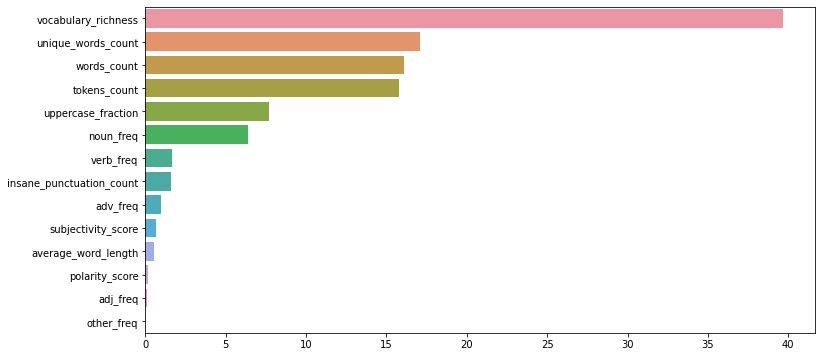

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(y=X.columns[features_sorted], x=fs.scores_[features_sorted], orient="h")

# Datasets

## Kaggle

In [ ]:
true, fake = read_data("True.csv", delimiter=','), read_data("Fake.csv", delimiter=',')
true, fake = true[1:], fake[1:]
true, fake = [a[1] for a in true if len(a[1]) > 20], [a[1] for a in fake if len(a[1]) > 20]

In [ ]:
true_df = extract_to_dataframe(true, 1)
fake_df = extract_to_dataframe(fake, -1)

In [ ]:
df_kaggle = pd.concat([true_df, fake_df])
df_kaggle = df_kaggle.reset_index(drop=True)

### reading part of data in batches for bag of words

In [ ]:
true, fake = np.random.choice(true, 6000, replace=False), np.random.choice(fake, 6000, replace=False)

In [ ]:
batch_size = 200
size = max(len(true), len(fake))
n_iters = (size-1)//batch_size + 1

df = pd.DataFrame()
bow_df = pd.DataFrame()

for t in range(n_iters):
    print("Iteration: ", t, " /", n_iters)

    print("Feature extraction")
    true_df = extract_to_dataframe(true[t*batch_size : (t+1)*batch_size], 1)
    fake_df = extract_to_dataframe(fake[t*batch_size : (t+1)*batch_size], -1)
    true_bow = extract_bow(true[t*batch_size : (t+1)*batch_size])
    fake_bow = extract_bow(fake[t*batch_size : (t+1)*batch_size])
    df = pd.concat([df, true_df, fake_df])
    bow_df = pd.concat([bow_df, true_bow, fake_bow]).fillna(0)
    print("Feature selection")
    fs = SelectKBest(score_func=f_classif, k=2000)
    fs.fit(bow_df, df.iloc[:, 0])
    features = fs.get_support(indices=True)
    bow_df = bow_df[bow_df.columns[features]]

    output.clear()

Iteration:  46  / 50
Feature extraction



Feature selection


In [ ]:
bow_df = pd.concat([df, bow_df], axis=1)

### no bow, rbf

In [ ]:
train_df, test_df = train_test_split(df_kaggle, test_size=0.3)

train_X, train_Y = train_df.iloc[:, 1:], train_df.iloc[:, 0]
test_X, test_Y = test_df.iloc[:, 1:], test_df.iloc[:, 0]

scaler = StandardScaler()
scaler.fit(train_X)
train_X = pd.DataFrame(scaler.transform(train_X))
test_X = pd.DataFrame(scaler.transform(test_X))

In [ ]:
clf = svm.SVC(kernel='rbf')
clf.fit(train_X, train_Y)
res_test = clf.predict(test_X)
res_train = clf.predict(train_X)

In [ ]:
print(accuracy(res_test, test_Y))
print(accuracy(res_train, train_Y))

(0.837579137775098, 1333, 822)
(0.8439125238233679, 3034, 1798)


#### model on our data

In [ ]:
real_train = [row[1] for row in read_data('reliable-train.csv')]
real_test  = [row[1] for row in read_data('reliable-test.csv')]
fake_train = [row[1] for row in read_data('zlo_train.csv')]
fake_test  = [row[1] for row in read_data('zlo_test.csv')]

real = real_train + real_test
fake = fake_train + fake_test

df_real, df_fake = extract_to_dataframe(real, 1), extract_to_dataframe(fake, -1)

df_our = pd.concat([df_real, df_fake])
df_our = df_our.reset_index(drop=True)
our_X, our_Y = df_our.iloc[:, 1:], df_our.iloc[:, 0]
our_X = pd.DataFrame(scaler.transform(our_X))

In [ ]:
res_our = clf.predict(our_X)

In [ ]:
print(accuracy(res_our, our_Y))

(0.5120772946859904, 27, 74)


### no bow, linear

In [ ]:
train_df, test_df = train_test_split(df_kaggle, test_size=0.3)

train_X, train_Y = train_df.iloc[:, 1:], train_df.iloc[:, 0]
test_X, test_Y = test_df.iloc[:, 1:], test_df.iloc[:, 0]

scaler = StandardScaler()
scaler.fit(train_X)
train_X = pd.DataFrame(scaler.transform(train_X))
test_X = pd.DataFrame(scaler.transform(test_X))

In [ ]:
clf = svm.SVC(kernel='linear')
clf.fit(train_X, train_Y)
res_test = clf.predict(test_X)
res_train = clf.predict(train_X)

In [ ]:
print(accuracy(res_test, test_Y))
print(accuracy(res_train, train_Y))

(0.7809014169430208, 1652, 1255)
(0.7768194592499273, 3909, 3000)


#### model on our data

In [ ]:
real_train = [row[1] for row in read_data('reliable-train.csv')]
real_test  = [row[1] for row in read_data('reliable-test.csv')]
fake_train = [row[1] for row in read_data('zlo_train.csv')]
fake_test  = [row[1] for row in read_data('zlo_test.csv')]

real = real_train + real_test
fake = fake_train + fake_test

df_real, df_fake = extract_to_dataframe(real, 1), extract_to_dataframe(fake, -1)

df_our = pd.concat([df_real, df_fake])
df_our = df_our.reset_index(drop=True)
our_X, our_Y = df_our.iloc[:, 1:], df_our.iloc[:, 0]
our_X = pd.DataFrame(scaler.transform(our_X))

In [ ]:
res_our = clf.predict(our_X)

In [ ]:
print(accuracy(res_our, our_Y))

(0.4975845410628019, 38, 66)


### with bow (smaller dataset, due to ram limitations)

In [ ]:
SVM_handpicked = pd.DataFrame(np.array([[73.9, 83.9, 4, 8], [84.8, 100, 3, 4]]),
                  columns=["acc_rate", "acc_on_training", "FN", "FP"], index=["rbf kernel w/o bag of words", "linear kernel w/ bag of words"])
SVM_combined_llo = pd.DataFrame(np.array([[72, 23, 35], [74.4, 33, 20], [80, 15, 27]]),
                  columns=["acc_rate", "FN", "FP"], index=["rbf kernel w/o bag of words", "linear kernel w/o bag of words", "linear kernel w/ bag of words"])
SVM_kaggle = pd.DataFrame(np.array([[78.1, 77.7, 1652, 1255], [83.8, 84.3, 1333, 822]]),
                  columns=["acc_rate", "acc_on_training", "FN", "FP"], index=["linear kernel w/o bag of words", "rbf kernel w/o bag of words"])
SVM_kaggle_our_tests = pd.DataFrame(np.array([[49.8, 38, 66], [51.2, 27, 74]]),
                  columns=["acc_rate", "FN", "FP"], index=["linear kernel w/o bag of words", "rbf kernel w/o bag of words", "linear kernel w/ bag of words"])

In [ ]:
# tasowanie i dzielenie
current_df = temp.sample(frac=1).reset_index(drop=True)
X, Y = current_df.iloc[:, 1:], current_df.iloc[:,0]
size = 6000
train_X, train_Y = X[:size], Y[:size]
test_X, test_Y = X[size:], Y[size:]

In [ ]:
clf = svm.SVC(kernel= 'linear')
clf.fit(train_X, train_Y)
res_test = clf.predict(test_X)
res_train = clf.predict(train_X)

In [ ]:
print(accuracy(res_test, test_Y))
print(accuracy(res_train, train_Y))

0.9942222222222222
1.0


### why it sucks

In [ ]:
def classify(article):
    if "Reuters" in article:
        return 1
    else:
        return -1

In [ ]:
misclassified = 0
for a in true:
    if classify(a) == -1:
        misclassified += 1
for a in fake:
    if classify(a) == 1:
        misclassified += 1

In [ ]:
size = len(true) + len(fake)
(size - misclassified) / size

0.9931333333333333

### Extra: feature importance

In [ ]:
def extract_to_dataframe(data, label):
    data_features = []

    for idx in tqdm(range(len(data))):
        article_features = extract(data[idx])
        selected_features = {
            'article_label': label,
            'tokens_count': article_features["tokens_count"],
            'words_count': article_features["words_count"], 
            'unique_words_count': article_features["unique_words_count"], 
            'polarity_score': article_features["polarity"], 
            'subjectivity_score': article_features["subjectivity"],
            'uppercase_fraction': article_features["uppercase_fraction"],
            'average_word_length': article_features["average_word_length"],
            'adj_freq': article_features["tag_fd"].freq("ADJ"), 
            'adv_freq': article_features["tag_fd"].freq("ADV"),
            'noun_freq': article_features["tag_fd"].freq("NOUN"),
            'verb_freq': article_features["tag_fd"].freq("VERB"),
            'other_freq': article_features["tag_fd"].freq("X"),
            'vocabulary_richness': article_features["unique_words_count"]/article_features["words_count"],
            'insane_punctuation_count': article_features["insane_punctuation_count"]
        }

        data_features.append(selected_features)

    df = pd.DataFrame.from_dict(data_features)

    return df

In [ ]:
true, fake = read_data("True.csv", delimiter=','), read_data("Fake.csv", delimiter=',')
true, fake = true[1:], fake[1:]
true, fake = [a[1] for a in true if len(a[1]) > 20], [a[1] for a in fake if len(a[1]) > 20]

In [ ]:
len(true)

21416

In [ ]:
true_df, fake_df = extract_to_dataframe(true, 1), extract_to_dataframe(fake, -1)

In [ ]:
df_kaggle = pd.concat([true_df, fake_df])
df_kaggle = df_kaggle.reset_index(drop=True)
X, Y = df_kaggle.iloc[:, 1:], df_kaggle.iloc[:, 0]


In [ ]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X, Y)
features_sorted = np.argsort(fs.scores_)[::-1]

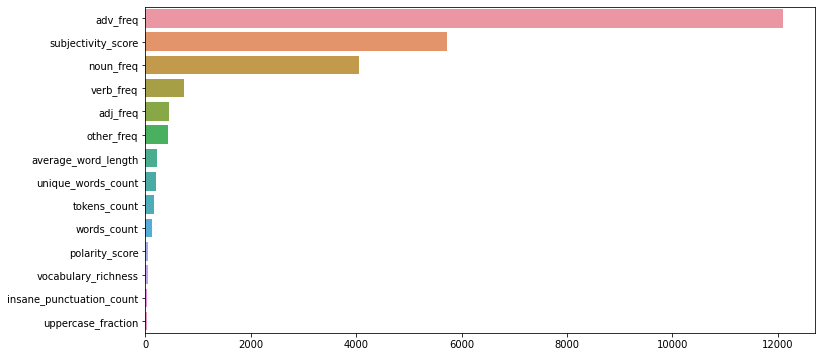

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(y=X.columns[features_sorted], x=fs.scores_[features_sorted], orient="h")

### Extra: Kaggle dataset with our model

In [ ]:
real_train = [row[1] for row in read_data('reliable-train.csv')]
real_test  = [row[1] for row in read_data('reliable-test.csv')]
fake_train = [row[1] for row in read_data('zlo_train.csv')]
fake_test  = [row[1] for row in read_data('zlo_test.csv')]

real = real_train + real_test
fake = fake_train + fake_test

In [ ]:
df_real, df_fake = extract_to_dataframe(real, 1), extract_to_dataframe(fake, -1)

In [ ]:
df = pd.concat([df_real, df_fake])
df = df.reset_index(drop=True)

In [ ]:
kaggle_X, kaggle_Y = df_kaggle.iloc[:, 1:], df_kaggle.iloc[:, 0]

In [ ]:
our_X, our_Y = df.iloc[:, 1:], df.iloc[:, 0]
scaler = StandardScaler()
scaler.fit(our_X)
our_X = pd.DataFrame(scaler.transform(our_X))
kaggle_X = pd.DataFrame(scaler.transform(kaggle_X))

In [ ]:
clf = svm.SVC()
clf.fit(our_X, our_Y)
res = clf.predict(kaggle_X)

In [ ]:
accuracy(res, kaggle_Y)

(0.6046579988694177, 5473, 12011)

## medium

https://medium.com/analytics-vidhya/fake-news-detection-using-python-learn-data-science-in-2020-80a45727a67b

In [ ]:
news = read_data("news.csv", delimiter=',')
real = [row[2] for row in news if len(row) == 4 and len(row[2]) > 20 and row[3] == 'REAL']
fake = [row[2] for row in news if len(row) == 4 and len(row[2]) > 20 and row[3] == 'FAKE']

In [ ]:
df_real, df_bow_real = extract_to_dataframe(real, 1)
df_fake, df_bow_fake = extract_to_dataframe(fake, -1)

In [ ]:
df = pd.concat([df_real, df_fake])
df_bow = pd.concat([df_bow_real, df_bow_fake]).fillna(0)
df_bow = pd.concat([df, df_bow], axis=1)

### no bow

In [ ]:
# tasowanie i dzielenie
current_df = df.sample(frac=1).reset_index(drop=True)
X, Y = current_df.iloc[:, 1:], current_df.iloc[:,0]
size = 160
train_X, train_Y = X[:size], Y[:size]
test_X, test_Y = X[size:], Y[size:]

In [ ]:
clf = svm.SVC(kernel= 'rbf')
clf.fit(train_X, train_Y)
res_test = clf.predict(test_X)
res_train = clf.predict(train_X)

In [ ]:
print(accuracy(res_test, test_Y))
print(accuracy(res_train, train_Y))

(0.7142857142857143, 6, 12)
(0.65625, 23, 32)
